In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

In [2]:
import torch
import torch.nn as nn

In [3]:
# https://driz2le.tistory.com/270
torch.cuda.is_available()

True

In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla V100-PCIE-32GB


device(type='cuda')

In [5]:
torch.cuda.device_count()

3

In [44]:
class Classifier(nn.Module):
    def __init__(self):
        # 부모 클래스 초기화
        super().__init__()
    
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 10),
            nn.Sigmoid()
        )
        self.model.cuda()
        
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # 변수 초기화
        self.counter = 0
        self.progress = []
        
        
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        # 신경망 출력 계산
        inputs = inputs.cuda()
        outputs = self.forward(inputs)
        
        # 손실 계산
        loss = self.loss_function(outputs, targets)
        
        # 카운터 증가, 10회마다 오차 저장
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        
        if (self.counter % 10000 == 0):
            print(f"counter = {self.counter}")
            pass
        
        # 기울기 초기화, 역전파 실행, 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0, 0.1), figsize=(16, 8), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5))
        pass
    

In [40]:
from torch.utils.data import Dataset

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # 이미지 목표(레이블)
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # 0~255이미지를 0~1로 정규화
        image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values)/255.0
        
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
        plt.title(f"label= {self.data_df.iloc[index, 0]}")
        plt.imshow(img, interpolation="none", cmap="Blues")
        pass
    
    pass
        
        

In [31]:
mnist_dataset = MnistDataset("./myo_gan/mnist_train.csv")

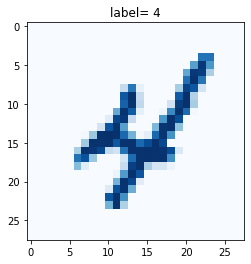

In [32]:
mnist_dataset.plot_image(9)

In [33]:
C = Classifier()

In [34]:
%%time
for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass

CPU times: user 1min 27s, sys: 1.91 s, total: 1min 29s
Wall time: 1min 29s


In [41]:
%%time

# 신경망 생성
C = Classifier()

# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
    print(f"training epoch: {i+1} of {epochs}")
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass


training epoch: 1 of 3
counter = 10000
counter = 20000
counter = 30000
counter = 40000
counter = 50000
counter = 60000
training epoch: 2 of 3
counter = 70000
counter = 80000
counter = 90000
counter = 100000
counter = 110000
counter = 120000
training epoch: 3 of 3
counter = 130000
counter = 140000
counter = 150000
counter = 160000
counter = 170000
counter = 180000
CPU times: user 4min 21s, sys: 5.88 s, total: 4min 27s
Wall time: 4min 28s


<AxesSubplot:>

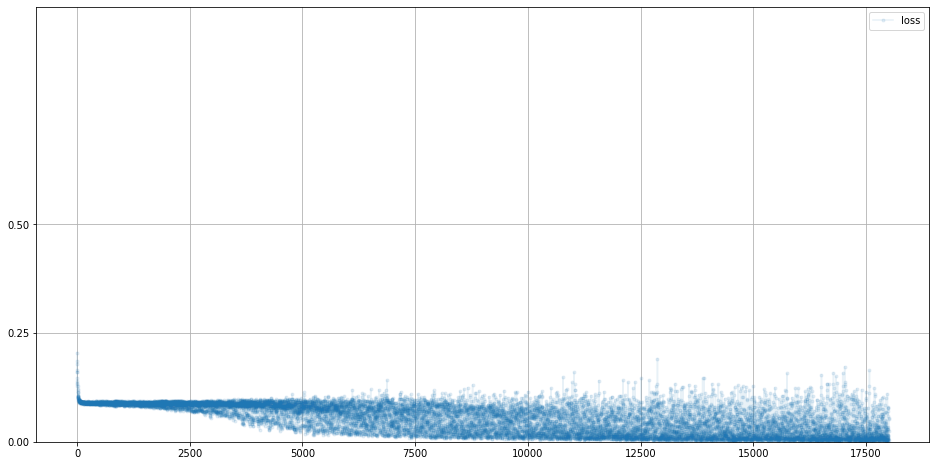

In [47]:
df = pd.DataFrame(C.progress, columns=["loss"])
df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5))

In [49]:
mnist_test_dataset = MnistDataset("./myo_gan/mnist_test.csv")

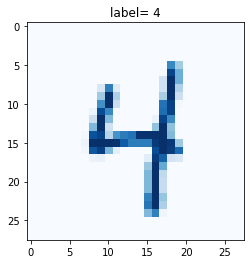

In [50]:
record = 19
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

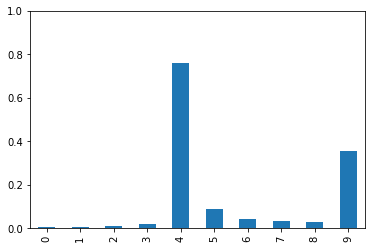

In [61]:
image_data = mnist_test_dataset[record][1].cuda()
output = C.forward(image_data)

pd.DataFrame(output.detach().cpu().numpy()).plot(kind="bar", legend=False, ylim=(0, 1))

In [63]:
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor.cuda()).detach().cpu().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    

In [64]:
score

8677